**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark 
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [ ]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 373MB/s]


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

The "fit_on_texts" method takes text as an input and creates a dictionary by assigning a number to each word of the input. This dictionary is typically called word_index due to its structure, {word: index}.

For example, 

input: "My name is India"

fit_on_texts: {"My": 1, "name": 2, "is": 3, "India": 4"}

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

The "texts_to_sequences" method turns the input into a sequence of integers. It does this by comparing the words in the input to the words in the dictionary. If the word is in the dictionary, replace it with the corresponding number. If it is not, leave a blank space in the sequence.

For example:

dictionary: {"My": 1, "name": 2, "is": 3, "India": 4"}

input: "Her name is India"

texts_to_sequence: [   ,2,3,4]

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

The "pad_sequences" method makes sure that all of the inputs to the neural network have uniform length. This is accomplished by adding 0s to each sequence until it is the same length as the longest sequence. The 0s can be added at the beginning or end of the sequence depending on how the pad_sequences method is applied. 

In this example, pad_sequences(sequences, padding='post')

[1,4,3,5,6]

[7,3,2,0,0]

[3, ,4,2,0]

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [ ]:
print("\n\n messages_train[20]: \n", messages_train[20])
print("\n length messages_train[20]:", len(messages_train[20]))



 messages_train[20]: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  324 1710    6    3  194  637   61  326   19
  221  335   15    1  112    4    1  204    2    3  206  103   15  455
    4    1  353  481    6  568  299   15    3  326   19  259  530   22
   67  380   12  501 1412    9   11  149  187  243   36    1  437  559
  188    1 1593   23  799   14   69   14    1  735  948  134   20    1
 1595  486   10   98  380    8    1  952  699    2   57 1914    8    1
  674   12   47    4    1  150 1531   23   21  179    8   65  578   18
  281  172   11  149  187  243   36    1  437  559    4  168    4  324
    1  174    2  906   25  371  215   53   16  137  310  133    2   14
    3  223   10   58  541  377   11  204    5  455  

messages_train[20] has the length of 200, the maximum length of a review on IMDb. However, a significant number of the "words" are actually 0s that were added in order to help the input reach the desired length (this is a result of the pad_sequences method). Unlike the example I gave in Q3, this input is padded at the beginning so the 0s are added at the beginning. This matches what I expected.

The only thing that doesn't seem to match what I expected is that there are no blank elements. My assumption is that this is because there were no unidentified words. 



# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

`__init__`: uses the size and the latent to initialize W (a weight matrix with random values from a truncated normal distribution). 

`__call__`: takes a sentence (x, of the form of JaxArray) and multiplies it with the matrix W. The result of the multiplication is a smaller vector.

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

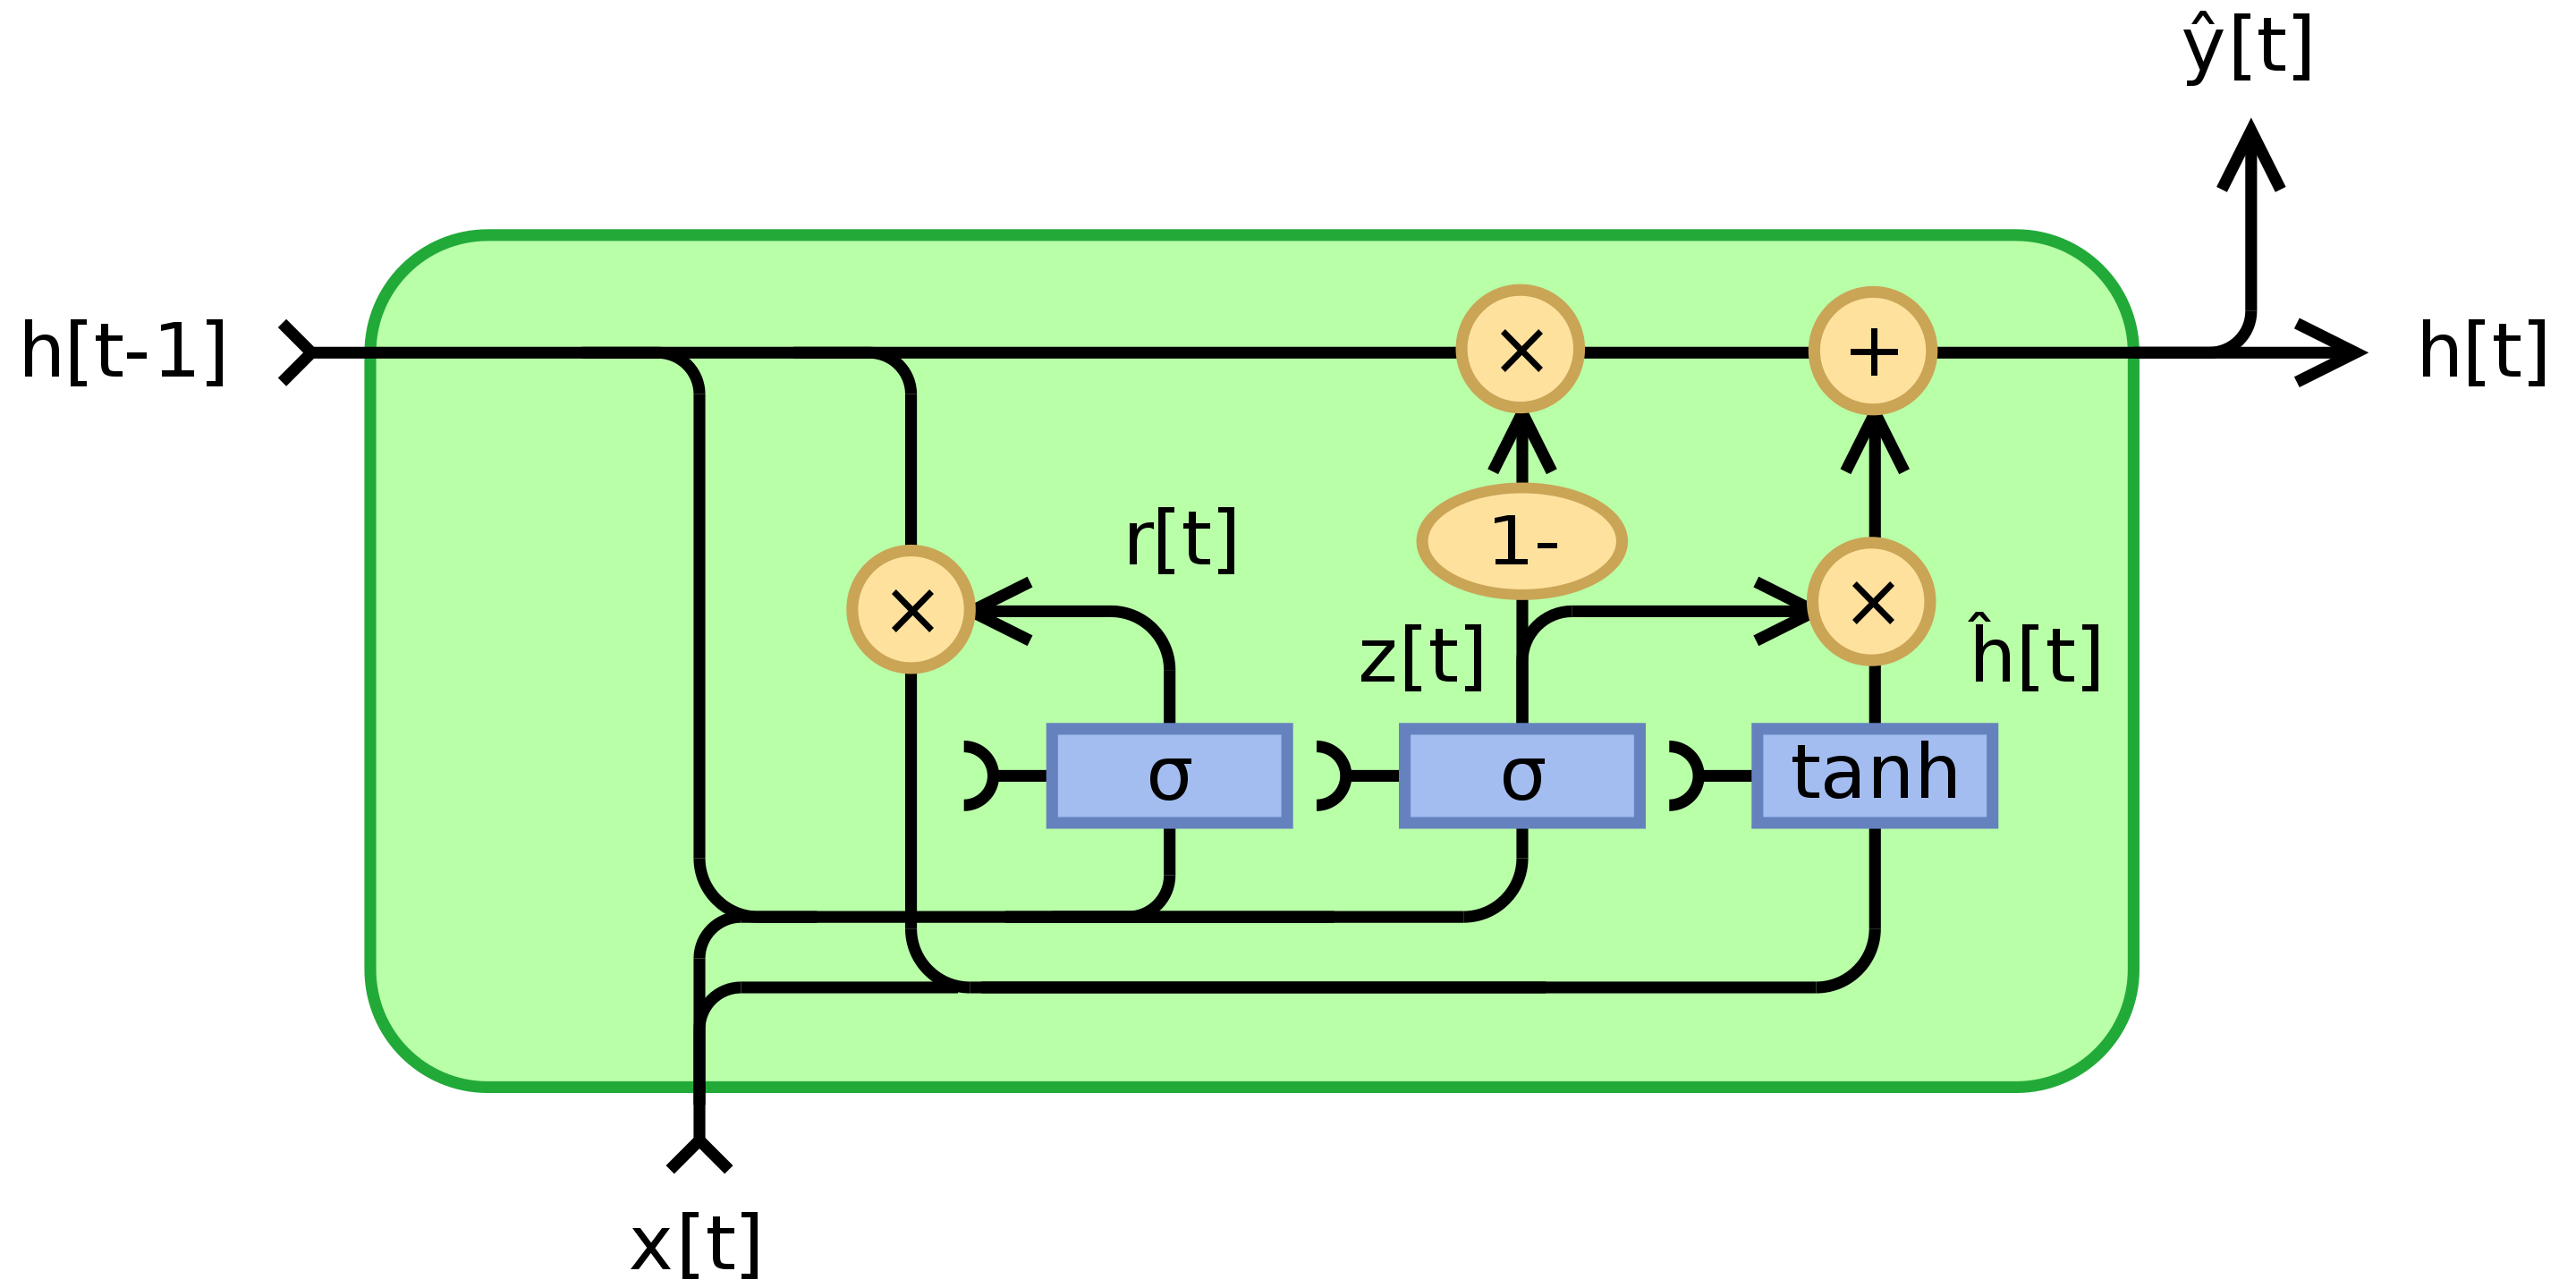

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.matmul(x, self.update_w.value) + jn.matmul(state, self.update_u.value) + self.update_b.value)
  
            # fill this in
            reset_gate = objax.functional.sigmoid(jn.matmul(x, self.reset_w.value) + jn.matmul(state, self.reset_u.value) + self.reset_b.value)

            # fill this in
            output_gate = objax.functional.tanh(jn.matmul(x, self.output_w.value) + jn.matmul(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value)

            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

According to the [JAX documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html), lax.scan "scans a function over leading array axes while carrying along a state." It is used as a replacement for for-loops with carry-over. It is very useful for reducing the compilation time when executing an RNN over many timesteps. This is better because Python loops are unrolled and therefore take much longer to compile the for-loops of an RNN.

lax.scan takes in three paramaters of different types. These parameters include f (a function that needs to be iterated through), init (the initial loop carry value) and xs (the input to be scanned). Lax.scan returns a tuple of type (c, [b]).

Example:

Consider the array [5, 2, 11, 6, 9]. Lax.scan can be used to calculate the cumulative product of elements in this array. For this array, the desired result is [5, 10, 110, 660, 5940].

First, we will define the first parameter of lax.scan: f


```
def f(result, num):
  result *= num
  return result, result
```

Second, we will define the second parameter: init

> init = 0 since there is no carry over for this application


Finally, we define the third parameter: xs

> From the example above, let xs = [5, 2, 11, 6, 9]

Considering the definitions above, we get the following implementation of lax.scan



```
lastCarry, lastResult = lax.scan(f, init, xs)
```






# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),                         
            GRU(embedding_size, num_hidden_units_GRU),               
            objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
            objax.functional.relu,                                   
            objax.nn.Linear(num_hidden_units, 2) 
])

**Embed(max_vocab, embedding_size)** --> input to embedding layer is one-hot encoding of each review; embedding ayer converts this vector into a matrix

**GRU(embedding_size, num_hidden_units_GRU)** --> feed each row of this matrix into the GRU cell

**objax.nn.Linear(num_hidden_units_GRU, num_hidden_units)** --> feed output of the GRU into fully connected layer

**objax.functional.relu** --> ReLU activation function

**objax.nn.Linear(num_hidden_units, 2)** --> obtain positive or negative label from output layer

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 



See crowdmark submission for answer. Photo upload functionality not working on Google Colab...

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:

def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
# the following code was modified from assignment 4 part 2 question 2

avg_train_loss_epoch = []
avg_val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []

def train(EPOCHS= num_epochs, BATCH= batch_size, LEARNING_RATE= learning_rate):
  X_valid, Y_valid = validation_data
  X_train, Y_train = training_data
  
  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          ####################
          batch = train_indices[it:it+BATCH]
          ####################
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          ####################
          batch = val_indices[it:it+BATCH]
          ####################
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

train()
 


Epoch 0001  Training Loss 172.57 Validation Loss 171.05 Training Accuracy 55.46 Validation Accuracy 57.44
Epoch 0002  Training Loss 168.11 Validation Loss 165.11 Training Accuracy 60.59 Validation Accuracy 58.30
Epoch 0003  Training Loss 162.18 Validation Loss 159.54 Training Accuracy 63.40 Validation Accuracy 62.48
Epoch 0004  Training Loss 154.69 Validation Loss 146.70 Training Accuracy 66.62 Validation Accuracy 69.14
Epoch 0005  Training Loss 147.97 Validation Loss 136.96 Training Accuracy 69.39 Validation Accuracy 72.16
Epoch 0006  Training Loss 144.25 Validation Loss 166.42 Training Accuracy 71.11 Validation Accuracy 60.80
Epoch 0007  Training Loss 141.35 Validation Loss 127.86 Training Accuracy 72.87 Validation Accuracy 75.28
Epoch 0008  Training Loss 139.65 Validation Loss 141.22 Training Accuracy 72.90 Validation Accuracy 70.42
Epoch 0009  Training Loss 134.29 Validation Loss 123.73 Training Accuracy 74.48 Validation Accuracy 76.80
Epoch 0010  Training Loss 133.56 Validation Lo

In [ ]:
# accuracy on the test set
accuracy(test_data)

DeviceArray(0.8352, dtype=float32)

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

Given that the...

training accuracy = 85.84%

testing accuracy = 84.52%

... the generalization gap is 1.32%

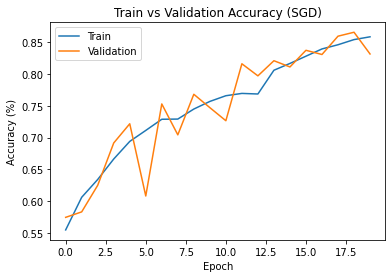

In [ ]:
  #Plot training loss (from A2 P2 Q2)
  plt.title("Train vs Validation Accuracy (SGD)")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),                         
          GRU(embedding_size, num_hidden_units_GRU),               
          objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
          objax.functional.relu,                                   
          objax.nn.Linear(num_hidden_units, 2) 
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:
# you code for the training loop should start here 
# the following code was modified from assignment 4 part 2 question 2

avg_train_loss_epoch_2 = []
avg_val_loss_epoch_2 = []
train_acc_epoch_2 = []
val_acc_epoch_2 = []

def train_2(EPOCHS= num_epochs, BATCH= batch_size, LEARNING_RATE= learning_rate):
  X_valid, Y_valid = validation_data
  X_train, Y_train = training_data
  
  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          ####################
          batch = train_indices[it:it+BATCH]
          ####################
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch_2.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch_2.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          ####################
          batch = val_indices[it:it+BATCH]
          ####################
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch_2.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch_2.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

train_2()


Epoch 0001  Training Loss 118.35 Validation Loss 78.47 Training Accuracy 77.62 Validation Accuracy 86.76
Epoch 0002  Training Loss 74.11 Validation Loss 74.51 Training Accuracy 88.42 Validation Accuracy 87.26
Epoch 0003  Training Loss 67.63 Validation Loss 69.70 Training Accuracy 89.48 Validation Accuracy 87.94
Epoch 0004  Training Loss 63.28 Validation Loss 69.32 Training Accuracy 90.26 Validation Accuracy 87.92
Epoch 0005  Training Loss 60.27 Validation Loss 69.56 Training Accuracy 90.77 Validation Accuracy 88.34
Epoch 0006  Training Loss 58.12 Validation Loss 70.03 Training Accuracy 91.23 Validation Accuracy 88.20
Epoch 0007  Training Loss 54.56 Validation Loss 75.55 Training Accuracy 91.80 Validation Accuracy 87.00
Epoch 0008  Training Loss 52.17 Validation Loss 74.43 Training Accuracy 92.18 Validation Accuracy 87.86
Epoch 0009  Training Loss 48.69 Validation Loss 73.99 Training Accuracy 92.88 Validation Accuracy 87.56
Epoch 0010  Training Loss 46.05 Validation Loss 79.89 Training 

In [ ]:
accuracy(test_data)

DeviceArray(0.8694, dtype=float32)

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

*Given that the...*

training accuracy = 97.17%

testing accuracy = 86.94%

... the generalization gap is 10.23%



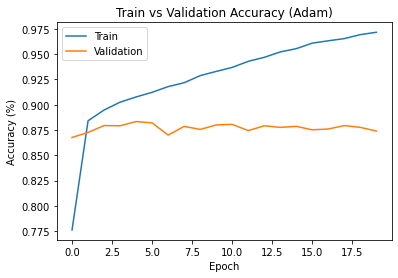

In [ ]:
#Plot Accuracy
plt.title("Train vs Validation Accuracy (Adam)")
plt.plot(train_acc_epoch_2, label="Train")
plt.plot(val_acc_epoch_2, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

When comparing the results between using the SDG and Adam optimizers, there are two key differences. 

Firstly, there is a significant difference in the generalization gaps. Although the Adama optimizer has an incredibly high training accuracy of 97.17%, the large generalization gap (10.23%) shows that the model does not perform well on new, hidden data. The SDG optimizer, while having a lower training accuracy, only has a generalization gap of 1.32% which shows that it performs much better on the test data set. 

Secondly, the two plots look very different. The validation accuracy, when using the SDG optimizer, closely follows the general shape of the training accuracy. When using the Adam optimizer, on the other hand, the validation accuracy is very "flat". Although the validation accuracy plateus near where the slope changes significantly for the training accuracy, the two lines are very different.



**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

**SGD (stochastic gradient descent)** works using gradient descent, as implied by its name. This optimizer calculates the gradient descent for all parameters in the nueral network using a single learning rate. This learning rate remains constant throughout the entire learning process. 

**Adam (Adaptive Moment Estimation)** computes adaptive learning rates for the model parameters. It can be thought of as an extension of SGD, expanding on the principle concept of SGD. Unlike SGD, Adam maintains an individual learning rate for each network parameter, updating each learning rate separately using calculations of an exponential moving average of both the gradient and square gradient. 

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),                         
          GRU(embedding_size, num_hidden_units_GRU),               
          objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
          objax.functional.relu,                                   
          objax.nn.Linear(num_hidden_units, 2) 
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.SGD(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
# you code for the training loop should start here 
# the following code was modified from assignment 4 part 2 question 2

avg_train_loss_epoch_3 = []
avg_val_loss_epoch_3 = []
train_acc_epoch_3 = []
val_acc_epoch_3 = []

def train_ES(EPOCHS= num_epochs, BATCH= batch_size, LEARNING_RATE= learning_rate, PATIENCE = max_patience_window):
  X_valid, Y_valid = validation_data
  X_train, Y_train = training_data
  
  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch_3.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch_3.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch_3.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch_3.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

      # since the max_patience_window is 5, the model will alow 5 epochs with no improvement before training is terminated. 
      # this means that if the validation accuracy does not improve after 5 epochs the training should terminate

      if PATIENCE < (epoch+1):  # start the checker once enough epochs have completed
          patience_val_acc_list = val_acc_epoch_3[epoch-PATIENCE: epoch+2]
          counter = 0
          for i in range(1, PATIENCE+1):
            if patience_val_acc_list[i] <= patience_val_acc_list[0]:
              counter += 1
          if counter == PATIENCE:
            break
          else:
            continue

train_ES()


Epoch 0001  Training Loss 172.72 Validation Loss 171.96 Training Accuracy 55.45 Validation Accuracy 51.94
Epoch 0002  Training Loss 169.60 Validation Loss 165.79 Training Accuracy 59.22 Validation Accuracy 58.22
Epoch 0003  Training Loss 162.98 Validation Loss 178.15 Training Accuracy 62.92 Validation Accuracy 55.02
Epoch 0004  Training Loss 155.42 Validation Loss 149.72 Training Accuracy 66.31 Validation Accuracy 65.96
Epoch 0005  Training Loss 149.27 Validation Loss 167.85 Training Accuracy 68.91 Validation Accuracy 59.02
Epoch 0006  Training Loss 145.74 Validation Loss 136.13 Training Accuracy 71.13 Validation Accuracy 72.54
Epoch 0007  Training Loss 141.14 Validation Loss 138.57 Training Accuracy 72.46 Validation Accuracy 72.60
Epoch 0008  Training Loss 139.13 Validation Loss 132.03 Training Accuracy 73.55 Validation Accuracy 74.14
Epoch 0009  Training Loss 135.86 Validation Loss 131.62 Training Accuracy 74.18 Validation Accuracy 74.46
Epoch 0010  Training Loss 130.97 Validation Lo

In [ ]:
accuracy(test_data)

DeviceArray(0.86640006, dtype=float32)

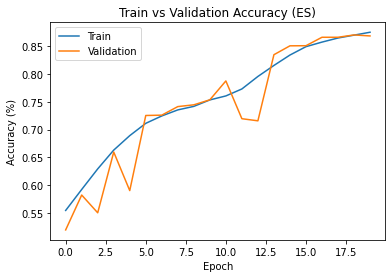

In [ ]:
#Plot training vs validation accuracy for the early stopping(ES)
plt.title("Train vs Validation Accuracy (ES)")
plt.plot(train_acc_epoch_3, label="Train")
plt.plot(val_acc_epoch_3, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

Given that the...

training accuracy = 87.53%

testing accuracy = 86.64%

... the generalization gap is 0.89%

*NOTE: early stopping did not occur here because the validation accuracy increased before reaching the max_patience_window. The functionality, however, was included in the model so would have worked if the conditions had been satisfied for early stopping. 

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

I think the third model (gru_rnn3) is the best. This optimization utilizes early stopping with SGD. I chose to use SGD (gru_rnn1) as the base for this optimization because it had a far smaller generalization gap than when using Adam (gru_rnn2).

This is the best model because it has the smallest generalization gap while maintaining a high test and training accuracy. Additionally, this model would be more efficient and would prevent running too many epochs and overfitting to the training data. 